<a href="https://colab.research.google.com/github/JawnMarc/Fellowship-AI-Challenge/blob/main/Pre_trained_RESNET34_on_imagewoof_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## FELLOWSHIP AI CHALLENGE
Use a pretrained ResNet34 and train on the imagewoof dataset. Use progressive resizing and discrimative learning rates. Measures its effect on your model's performance

### ResNet34
* [ResNet34](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet34)
* [Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)


### Imagewoof
* [Github](https://github.com/fastai/imagenette)
* [Downloads](https://s3.amazonaws.com/fast-ai-imageclas/imagewoof-320.tgz) 

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# load all modules and dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms, datasets

import numpy as np
import matplotlib.pyplot as plt
import logging

## Download Imagewoof Data

Imagewoof is a subset of 10 classes from Imagenet that aren't so easy to classify, since they're all dog breeds. The breeds are: ***Australian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, English foxhound, Rhodesian ridgeback, Dingo, Golden retriever, Old English sheepdog***.

* [Full size download](https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz)
* [320 px download](https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz)
* [160 px download.](https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz)

In [3]:
make directory and download data to target directory
%mkdir '/content/drive/MyDrive/ML_Exp_Res/FELLOWSHIP AI CHALLENGE/data'

!wget -P '/content/drive/MyDrive/ML_Exp_Res/FELLOWSHIP AI CHALLENGE/data' \
  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz

extract data to target directory
!tar -zxf '/content/drive/MyDrive/ML_Exp_Res/FELLOWSHIP AI CHALLENGE/data/imagewoof2-320.tgz' \
   -C '/content/drive/MyDrive/ML_Exp_Res/FELLOWSHIP AI CHALLENGE/data/'

In [4]:
## Labels

label_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

label_dict.items()

dict_items([('n02086240', 'Shih-Tzu'), ('n02087394', 'Rhodesian ridgeback'), ('n02088364', 'Beagle'), ('n02089973', 'English foxhound'), ('n02093754', 'Australian terrier'), ('n02096294', 'Border terrier'), ('n02099601', 'Golden retriever'), ('n02105641', 'Old English sheepdog'), ('n02111889', 'Samoyed'), ('n02115641', 'Dingo')])

## Enhance Size of Training Data with Data Augmentation Technique
The following Pytorch transforms `transforms.RandomResizedCrop(), transforms.RandomHorizontalFlip(), transforms.RandomRotation()` are used to augment the training image data. This technique enhances training data volume likely to boost model generalization ability and help resolve class imbalance issues.


An objective of this project is to adopt progressive resizing and its effect performace. In this case, the `augment_data` function is defined to take input arguments to allow different resize options. 

The resize options considered for this task are;
`width x height x channel(colour)`
* 128x128x3
* 224x224x3
* 229x229x3

To keep track of experiments and outputs, a logging file is configured using Python `logging` module.

In [5]:
# configuring experiment logs
logging.basicConfig(
    filename='/content/drive/MyDrive/ML_Exp_Res/FELLOWSHIP AI CHALLENGE/logs.txt',
    level=logging.INFO,
    format='%(asctime)s - %(name)s:%(levelname)s:%(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p'
)

In [6]:
# train and val data directory
data_dir = '/content/drive/MyDrive/ML_Exp_Res/FELLOWSHIP AI CHALLENGE/data/imagewoof2-320/'

In [7]:
def augment_data(progressive_resize, rand_rotation=45, batch_size=32, data_path=data_dir):
    '''
    A function to augment to image data with image transforms to enhance data
    volume and model generalization.

    params:
        progressive_resize (int):  dimension to resize image dimension to. 128px, 224px & 229px
        rand_rotation (int): random rotation degree of images
        batch_size (int): number of images batched per epoch
        data_path (str): path to image data
    
    return:
        trainloader: tuple of batch of images from train dataset
        validloader: tuple of batch of images from validation dataset
    '''
    
    train_dir = data_path + 'train'
    val_dir = data_path + 'val'

    # transform train and val data
    # 128x128x3, 224x224x3, and 229x229x3 progressive resizing technique
    train_transforms = transforms.Compose([transforms.RandomResizedCrop(progressive_resize),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(rand_rotation),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
                                        ])

    val_transforms = transforms.Compose([transforms.CenterCrop(progressive_resize),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                        ])


    # load dataset with imagefolder
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    valid_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    logging.info('Train and Validation data augmentation: SUCCESS')
    logging.info('Progressive resize - Image dimension set to %s x %s x 3', progressive_resize, progressive_resize)

    return trainloader, validloader

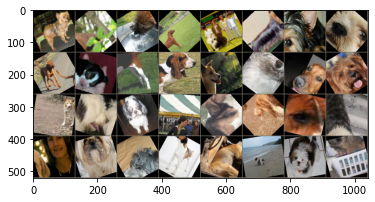

In [8]:
trainloader, _  = augment_data(128)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

## Build and train  model

In [9]:
# detect and use gpu if available of default to cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
logging.info('Hardware acceleration detected: %s', device)

In [10]:
#  defined training function
def train_n_validate_model(model, trainloader, validloader, optimizer, criterion,
                           scheduler, num_epochs=10, device=device):
    '''
    A function to train and validate model
    '''

    logging.info('Train and model validation started')

    # initiate list to save losses and accuracy for plot
    train_loss_scores = []
    valid_loss_scores = []
    accuracy_scores = []

    # model training loop
    for epoch in range(1, num_epochs+1):
        train_loss = 0
        valid_loss = 0
        accuracy = 0
        total = 0

        model.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # sets the gradients of all optimized torch.Tensor s to zero.
            optimizer.zero_grad()
            # forward and backward pass
            output = model.forward(inputs)
            loss = criterion(output, labels)
            loss.backward()
            # performs a single optimization step (parameter update).
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        # model validaltion loop
        model.eval()
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)    
            output = model.forward(inputs)
            loss = criterion(output, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, pred = torch.max(output.data, 1)
            total += labels.size(0)
            accuracy += (pred == labels).sum().item()

        # calc avg losses
        train_loss = train_loss/len(trainloader)
        valid_loss = valid_loss/len(validloader)

        # update scores to plot
        train_loss_scores.append(train_loss)
        valid_loss_scores.append(valid_loss)
        accuracy_scores.append(100*(accuracy/total))

        # scheduler is an LR scheduler object from torch.optim.lr_scheduler
        scheduler.step()        
    
        # print train, valid losses & validation  accuracy
        print_text = 'Epoch: {}\{} \tTraining Loss: {:.9f} \tValidation Loss: {:.9f} \tValidation Accuracy: {:.2f}%'.format(
            epoch, num_epochs, train_loss, valid_loss, 100*(accuracy/total))
        
        print(print_text)

        # logging info to file
        logging.info(print_text)
    
    return train_loss_scores, valid_loss_scores, accuracy_scores

In [11]:
def resnet_model_34(device=device):
    '''
    A function to download and load a pre-trained resnet 34

    param:
        device: To enable use of GPU or CPU to train model
    '''
    model = models.resnet34(pretrained=True)
    in_feat = model.fc.in_features

    # output samples is set to len of label dictionary
    model.fc = nn.Linear(in_feat, len(label_dict))
    model = model.to(device)

    return model

## Criterion, optimizer and scheduler definitions



In [12]:
# CrossEntropyLoss function to apply softmax to the output layer 
# to convert logits to probs
criterion = nn.CrossEntropyLoss()

# A discriminative learning rate is when you train a neural net with
# different learning rates for different layers. Sets the learning rate of each 
# parameter group according to cyclical learning rate policy (CLR).
# scheduler2 = lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.1)

# EXPERIMENT 1
### Pre-trained Resnet34 trained on Imagewoof scaled down to 128x128x3 along with discrimitive learninig rates.

In [13]:
# load image data and scale to 128px
trainloader_128, validloader_128 = augment_data(progressive_resize=128, batch_size=64)

# load pretrained resnet model
model_128 = resnet_model_34()

# fine tune all resnet34 parameters. FC layer reseted
optimizer_128 = optim.SGD(model_128.parameters(), lr=0.0001)

# sets the learning rate of each parameter group according to cyclical
# learning rate policy (CLR).
scheduler_128 = lr_scheduler.CyclicLR(optimizer_128, base_lr=0.0001, max_lr=0.1)

# train and validate model
train_loss_scores, valid_loss_scores, accuracy_scores = train_n_validate_model(
    model_128, trainloader_128, validloader_128, optimizer_128, criterion, scheduler_128, num_epochs=20)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Epoch: 1\20 	Training Loss: 130.847514826 	Validation Loss: 99.533220431 	Validation Accuracy: 53.09%
Epoch: 2\20 	Training Loss: 92.692356408 	Validation Loss: 69.570268427 	Validation Accuracy: 69.81%
Epoch: 3\20 	Training Loss: 69.988848068 	Validation Loss: 55.315817241 	Validation Accuracy: 75.24%
Epoch: 4\20 	Training Loss: 57.318298232 	Validation Loss: 45.156851207 	Validation Accuracy: 78.37%
Epoch: 5\20 	Training Loss: 50.224504335 	Validation Loss: 40.155549959 	Validation Accuracy: 80.83%
Epoch: 6\20 	Training Loss: 46.124388042 	Validation Loss: 36.200885683 	Validation Accuracy: 81.98%
Epoch: 7\20 	Training Loss: 42.135183715 	Validation Loss: 34.979977751 	Validation Accuracy: 82.31%
Epoch: 8\20 	Training Loss: 41.274034203 	Validation Loss: 34.881616785 	Validation Accuracy: 81.57%
Epoch: 9\20 	Training Loss: 38.912149231 	Validation Loss: 33.199904387 	Validation Accuracy: 82.57%
Epoch: 10\20 	Training Loss: 37.786883648 	Validation Loss: 32.090297653 	Validation Accur

# EXPERIMENT 1 OBSERVATIONS
* Model had a stable training till it each the 18th epoch.
* Model recorded the highest accuracy of 85.14% at epoch 18 and started to show signs of instabilty.
* Training further longer could potentially cause model to overfit.
* Imagewoof scaled down to 128px negatively imparted the model performance about 9-11% compared to the other model trained on 224px and 229px.

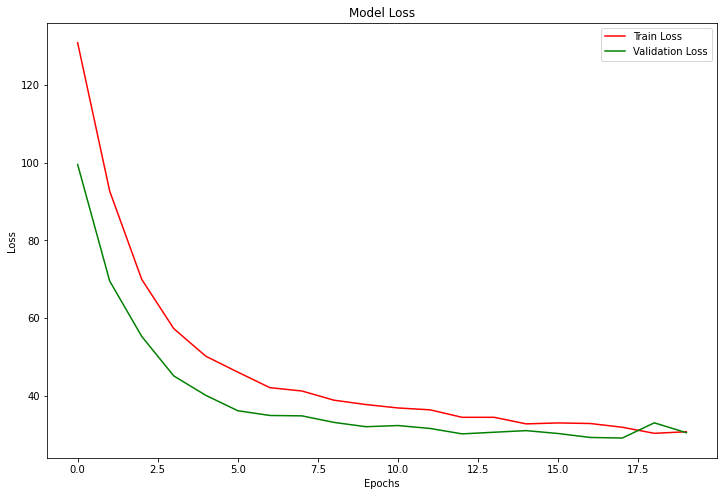

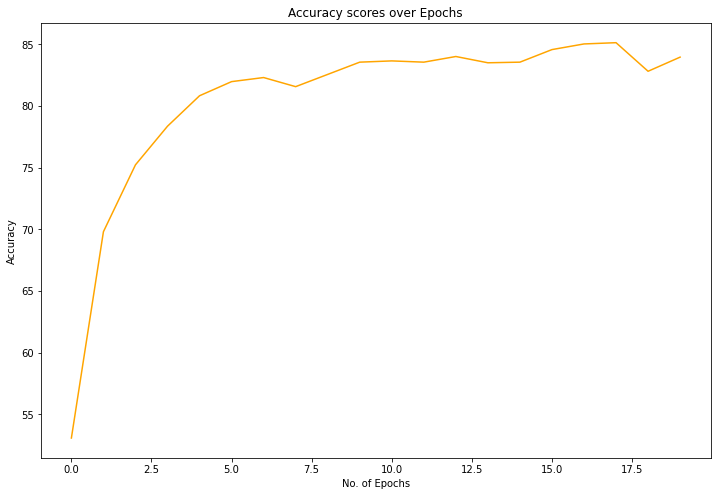

In [14]:
# Plot train loss and valid loss scores
plt.figure(figsize=(12,8))
plt.plot(train_loss_scores,label='Train Loss', color='red')
plt.plot(valid_loss_scores, label='Validation Loss', color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Plot accuracacy score
plt.figure(figsize=(12,8))
plt.plot(accuracy_scores, label='Accuracy score', color='orange')
plt.title('Accuracy scores over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.show()

# EXPERIMENT 2
### Pre-trained Resnet34 trained on Imagewoof scaled down to 224x224x3 along with discrimitive learninig rates.

In [15]:
# load image data and scale to 224px
trainloader_224, validloader_224 = augment_data(progressive_resize=224, batch_size=64)

# load pretrained resnet model
model_224 = resnet_model_34()

# fine tune all resnet34 parameters. FC layer reseted
optimizer_224 = optim.SGD(model_224.parameters(), lr=0.0001)

# sets the learning rate of each parameter group according to cyclical
# learning rate policy (CLR)
scheduler_224 = lr_scheduler.CyclicLR(optimizer_224, base_lr=0.0001, max_lr=0.1)

# train and validate model
train_loss_224, valid_loss_224, accuracy_scores_224 = train_n_validate_model(
    model_224, trainloader_224, validloader_224, optimizer_224, criterion, scheduler_224, num_epochs=20)

Epoch: 1\20 	Training Loss: 132.722572535 	Validation Loss: 98.185432596 	Validation Accuracy: 65.74%
Epoch: 2\20 	Training Loss: 85.586497930 	Validation Loss: 48.153024550 	Validation Accuracy: 86.49%
Epoch: 3\20 	Training Loss: 57.020971906 	Validation Loss: 28.830534719 	Validation Accuracy: 90.81%
Epoch: 4\20 	Training Loss: 44.070866143 	Validation Loss: 21.893403222 	Validation Accuracy: 91.68%
Epoch: 5\20 	Training Loss: 37.156645184 	Validation Loss: 17.705725542 	Validation Accuracy: 92.64%
Epoch: 6\20 	Training Loss: 34.589393043 	Validation Loss: 15.834597483 	Validation Accuracy: 92.85%
Epoch: 7\20 	Training Loss: 31.780987918 	Validation Loss: 14.846621664 	Validation Accuracy: 93.23%
Epoch: 8\20 	Training Loss: 30.837591818 	Validation Loss: 14.285515258 	Validation Accuracy: 93.03%
Epoch: 9\20 	Training Loss: 29.017823041 	Validation Loss: 13.670216433 	Validation Accuracy: 93.69%
Epoch: 10\20 	Training Loss: 27.306399661 	Validation Loss: 13.310017402 	Validation Accur

# EXPERIMENT 2 OBSERVATIONS
* Model had a stable training throughout training times.
* Model recorded the highest accuracy of 94.02% at epoch 18.
* Training further longer could potentially cause model to improve or overfit.
* Train losses and validations losses shows that, the traininf losses continue to decrease as the validation losses start to increase after the 18th epoch

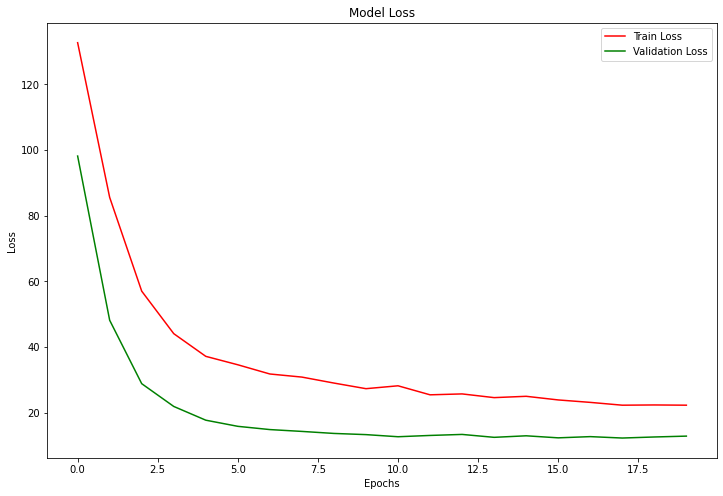

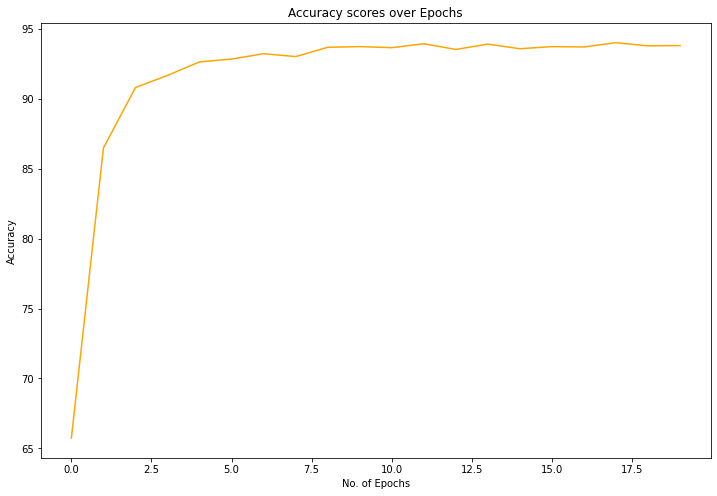

In [16]:
# Plot train loss and valid loss scores
plt.figure(figsize=(12,8))
plt.plot(train_loss_224, label='Train Loss', color='red')
plt.plot(valid_loss_224, label='Validation Loss', color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Plot accuracacy score
plt.figure(figsize=(12,8))
plt.plot(accuracy_scores_224, label='Accuracy score', color='orange')
plt.title('Accuracy scores over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.show()

# EXPERIMENT 3
### Pre-trained Resnet34 trained on Imagewoof scaled down to 229x229x3 along with discrimitive learninig rates.

In [ ]:
# load image data and scale to 229px
trainloader_229, validloader_229 = augment_data(progressive_resize=229, batch_size=64)

# load pretrained resnet model
model_229 = resnet_model_34()

# fine tune all resnet34 parameters. FC layer reseted
optimizer_229 = optim.SGD(model_229.parameters(), lr=0.0001)

# sets the learning rate of each parameter group according to cyclical
# learning rate policy (CLR).
scheduler_229 = lr_scheduler.CyclicLR(optimizer_229, base_lr=0.0001, max_lr=0.1)

# train and validate model
train_loss_229, valid_loss_229, accuracy_scores_229 = train_n_validate_model(
    model_229, trainloader_229, validloader_229, optimizer_229, criterion, scheduler_229, num_epochs=20)

Epoch: 1\20 	Training Loss: 133.120610533 	Validation Loss: 103.190342557 	Validation Accuracy: 61.54%
Epoch: 2\20 	Training Loss: 90.879674520 	Validation Loss: 52.711354554 	Validation Accuracy: 85.21%
Epoch: 3\20 	Training Loss: 60.146488606 	Validation Loss: 30.069103144 	Validation Accuracy: 89.92%
Epoch: 4\20 	Training Loss: 45.361807177 	Validation Loss: 22.911234648 	Validation Accuracy: 91.24%
Epoch: 5\20 	Training Loss: 38.725316803 	Validation Loss: 17.421651031 	Validation Accuracy: 92.54%
Epoch: 6\20 	Training Loss: 34.778389306 	Validation Loss: 15.285040209 	Validation Accuracy: 93.18%
Epoch: 7\20 	Training Loss: 32.757742556 	Validation Loss: 14.854398056 	Validation Accuracy: 93.13%
Epoch: 8\20 	Training Loss: 30.821961944 	Validation Loss: 14.054655882 	Validation Accuracy: 93.41%
Epoch: 9\20 	Training Loss: 28.770189752 	Validation Loss: 13.448116806 	Validation Accuracy: 92.90%
Epoch: 10\20 	Training Loss: 28.567947321 	Validation Loss: 12.745925008 	Validation Accu

# EXPERIMENT 3 OBSERVATIONS
* Model had a stable training throughout training times.
* Model recorded the highest accuracy of 94.30% at epoch 14.
* Training further longer could potentially cause model to improve or overfit.
* Train losses and validations losses shows that, the training losses continue to decrease as the validation losses start to show signs of instability after epoch 14

In [5]:
# Plot train loss and valid loss scores
plt.figure(figsize=(12,8))
plt.plot(train_loss_229,label='Train Loss', color='red')
plt.plot(valid_loss_229, label='Validation Loss', color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Plot accuracacy score
plt.figure(figsize=(12,8))
plt.plot(accuracy_scores_229, label='Accuracy score', color='orange')
plt.title('Accuracy scores over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.show()

## EXTRA
[Other models](https://github.com/fastai/imagenette#imagewoof-leaderboard) found online showed similarly model performance to what my models. In experiment 1, image size of 128px and after 5 epochs, my model shot an accuracy of 71.47% (mean)


| Exp | Size(px) | Epochs | Accuracy| # Runs |
| :---| :---|:----:|---:|---:|
| 1 | 128 | 5    | 71.47%  | 5, mean |
| 1 | 128 | 20   | 84.31%    | last 5, mean |
| 2 | 224 | 5    | 85.47%  | 5, mean |
| 2 | 224 | 20   | 93.82%    | last 5, mean |
| 3 | 229 | 5    | 84.10%  | 5, mean |
| 3 | 229 | 20   | 94.01%    | last 5, mean |

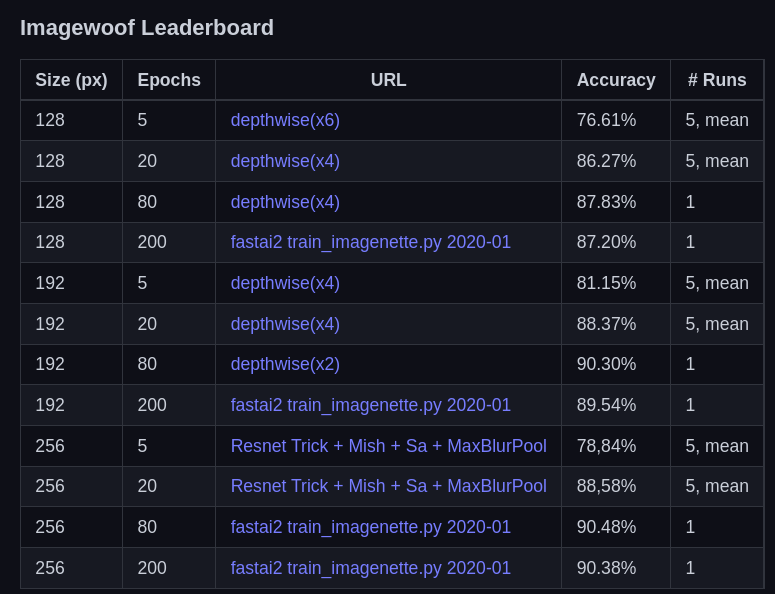